# Variational Mixture of Gaussians

$$
    p({\bf x}) = \sum_{k=1}^K \pi_k \mathcal{N}\left({\bf x} \vert \boldsymbol\mu_k, \boldsymbol\Sigma_k\right)
$$

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from scipy.special import digamma, gamma, loggamma
from numpy.linalg import det, inv
from scipy.stats import multivariate_normal, wishart, dirichlet
from numpy.random import seed, randn

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (8, 4)
np.set_printoptions(suppress=True, precision=3)

In [3]:
url = ("https://gist.githubusercontent.com/curran/"
       "4b59d1046d9e66f2787780ad51a1cd87/raw/"
       "9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv")

In [4]:
def plot_mixtures(X, r, mu, pi, Sigma, step=0.01, cmap="viridis", levels=1):
    colors = ["tab:red", "tab:blue", "tab:green",
              "tab:cyan", "tab:orange", "tab:purple"]
    x0, y0 = X.min(axis=0)
    x1, y1 = X.max(axis=0)
    xx, yy = np.mgrid[x0:x1:step, y0:y1:step]
    zdom = np.c_[xx.ravel(), yy.ravel()]
    Nk = r.sum(axis=0)
    
    # Plotting distributions whose effective number of
    # observations is at least 1
    Norms = [multivariate_normal(mean=mui, cov=Sigmai)
             for mui, Sigmai, N in zip(mu, Sigma, Nk) if N > 1]
    
    for Norm, color in zip(Norms, colors):
        density = Norm.pdf(zdom).reshape(xx.shape)
        plt.contour(xx, yy, density, levels=levels,
                    colors=color, linewidths=3)
        
    plt.scatter(*X.T, alpha=0.7, c=r.argmax(axis=1), cmap=cmap)
    plt.xlim(x0, x1)
    plt.ylim(y0, y1)

Let ${\bf X} = \{x_n\}_{n=1}^N$ a dataset of i.i.d. mixture of Gaussians with parameters $\boldsymbol \pi = \{\pi_k\}_{k=1}^K$, $\boldsymbol \mu= \{\mu_k\}_{k=1}^K$, $\boldsymbol \Lambda= \{\Lambda_k\}_{k=1}^K$ and latent variables ${\bf Z}=\{z_n\}_n$.

The likelihood distribution is defined to be

$$
\begin{aligned}
    p({\bf x} \vert {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) &= p({\bf x} \vert {\bf z}, {\boldsymbol \mu}, {\boldsymbol \lambda}) p({\bf z} \vert {\boldsymbol \pi}) \\
    &= \prod_{n=1}^N\prod_{k=1}^K \mathcal{N}\left(x_n \vert \mu_k, \Lambda_k^{-1}\right)^{z_{nk}} \cdot \prod_{n=1}^N\prod_{k=1}^K \pi_k^{z_{nk}}
\end{aligned}
$$

Thus, the full joint distribution factorizes as follows:

$$
\begin{aligned}
p({\bf x} , {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) &= p({\bf x} \vert {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) p({\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) \\
&= p({\bf x} \vert {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) p(\boldsymbol \pi) p({\bf z} \vert \boldsymbol \pi) p(\boldsymbol \mu \vert \boldsymbol \Lambda) p(\boldsymbol \Lambda)
\end{aligned} 
$$

We now introduce conjugate priors of the form

$$
    p(\boldsymbol\pi) = \text{Dir}(\boldsymbol \pi \vert \alpha_0)
$$

$$
   p(\boldsymbol\mu\vert\boldsymbol\Lambda) = \prod_{k=1}^K \mathcal{N}\left(\mu_k\vert{\bf m}_0, (\beta_0\Lambda_k)^{-1}\right)
$$

$$
   p(\boldsymbol\Lambda) = \prod_{k=1}^K \mathcal{W}(\Lambda_k\vert{\bf W}_0, \nu_0)
$$

Next, we consider a variational distribution that factorizes between latent variables ($\bf z$) and parameters ($\boldsymbol\pi, \boldsymbol\mu, \boldsymbol\Lambda$):

$$
    q({\bf z}, \boldsymbol\pi, \boldsymbol\mu, \boldsymbol\Lambda) = q({\bf z})q(\boldsymbol\pi, \boldsymbol\mu, \boldsymbol\lambda)
$$

---

In general, a factorized variational approximation to a full joint distribution of observed variables ($\bf x$) and hidden variables ($\bf z$) satisfies

$$
    \log q_j^*(z_j) = \mathbb{E}_{m\neq j}\left[\log p({\bf x}, {\bf z})\right] + C
$$


Which involves the following computation for our problem:

$$
    \log q({\bf z}) = \mathbb{E}_{\boldsymbol\pi, \boldsymbol\mu, \boldsymbol\Lambda}\left[\log p({\bf x} , {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda})\right] + C
$$

$$
    \log q(\boldsymbol\pi, \boldsymbol\mu, \boldsymbol\Lambda) = \mathbb{E}_{\bf z}\left[\log p({\bf x} , {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda})\right] + C
$$

It turns out that 

$$
    q^*({\bf z}) = \prod_{n=1}^N\prod_{k=1}^K r_{nk}^{z_{nk}}
$$

With 
* $r_{nk} = \frac{\rho_{nk}}{\sum_j\rho_{nj}}$,
* $\log \rho_{nk} = \mathbb{E}_{\pi}[\log \pi_k] + \frac{1}{2}\mathbb{E}_{\boldsymbol \Lambda}[\log\vert\Lambda_k\vert] - \frac{M}{2}\log 2\pi - \frac{1}{2}\mathbb{E}_{\boldsymbol \mu, \boldsymbol \Lambda}\left[(x_n - \mu_k)^T\Lambda_k(x_n - \mu_k)\right]$
    * $\mathbb{E}_{\pi}[\log \pi_k] = \psi(\alpha_k) - \psi(\hat{\boldsymbol\alpha})$
    * $\mathbb{E}_{\boldsymbol \Lambda}\left[\log\vert\Lambda_k\vert\right] = \sum_{m=1}^M\psi\left(\frac{\nu_k + 1 - M}{2}\right) + M\log2 + \log\vert{\bf w}_k\vert$
    * $\mathbb{E}_{\boldsymbol \mu, \boldsymbol \Lambda}\left[(x_n - \mu_k)^T\Lambda_k(x_n - \mu_k)\right] = \nu_k(x_n - {\bf m}_k)^T {\bf w}_k(x_n - {\bf m}_k) + M\beta^{-1}_k$


* $\psi(a) = \frac{d}{da}\Gamma(a)$
* $\hat{\boldsymbol\alpha} = \sum_k\alpha_k$

---


$$
    q^*(\boldsymbol\pi) = \text{Dir}(\boldsymbol\pi | \boldsymbol\alpha)
$$

With
* $\boldsymbol\alpha_k = \alpha_0 + N_k$

---

$$
    q^{*}(\mu_k |  \Lambda_k) = \mathcal{N}\left(\mu_k |  {\bf m}_k, (\beta_k \Lambda_k)^{-1}\right)
$$

With
* $\beta_k = \beta_0 + N_k$
* ${\bf m}_k = \frac{1}{\beta_k}(\beta_0{\bf m}_0 + N_k\bar{\bf x}_k)$

---

$$
    q^{*}(\Lambda_k) = \mathcal{W}(\Lambda_k | {\bf w}_k, \nu_k)
$$

With
* $\nu_k$ = $\nu_0 + N_k$
* ${\bf w}_k^{-1} = {\bf w}_0 + N_kS_k + \frac{\beta_0N_k}{\beta_0 + N_k}(\bar{\bf x}_k - {\bf m}_0)(\bar{\bf x}_k - {\bf m}_0)^T$


Where we have defined

$$
    N_k = \sum_{n=1}^N r_{nk} \tag{1}
$$

$$
    \bar{\bf x}_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk} {\bf x}_n \tag{2}
$$

$$
    S_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk} \big({\bf x}_n - \bar{\bf x}_k\big)\big({\bf x}_n - \bar{\bf x}_k\big)^T \tag{3}
$$

In [5]:
old_faithful = pd.read_table(url)

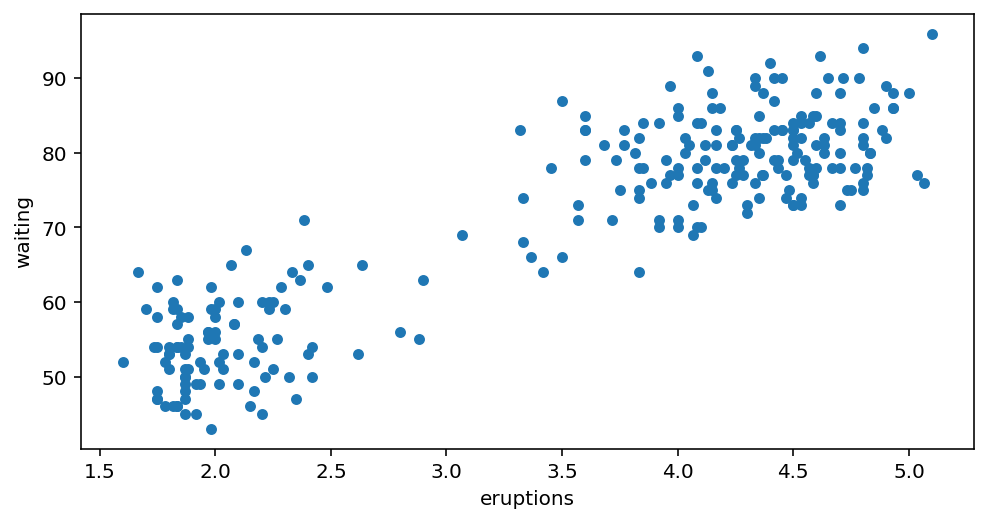

In [6]:
old_faithful.plot.scatter(x="eruptions", y="waiting")

### Variational E-step

Our first step in estimating a mixture density over the `old_faithful` dataset is to compute the responsibilities $r_{nk}$

In [7]:
X = old_faithful.values

In [8]:
# Prior parameters
N, M = X.shape
K = 6 # number of clusters
beta0 = 1
m0 = np.concatenate([X.mean(axis=0, keepdims=True).T] * 6, axis=1) # np.ones((M, K))
seed(314)
m0 = m0 + randn(2, 6) 
alpha0 = np.ones(K)
eta0 = 2 * np.ones(K)
W0 = np.concatenate([np.identity(M)[np.newaxis, ...]] * K, axis=0) / 100

In [9]:
E_logpi = digamma(alpha0) - digamma(alpha0.sum())

In [10]:
E_logLambda = digamma((eta0 + 1 - M) / 2) + M * np.log(2) + det(W0)

In [11]:
diffk = (X[:, None, :] - m0.T)
mpart = np.einsum("ijk, jkk -> ijk", diffk, W0)
E_mahal = eta0 * np.einsum("ijk, ijk -> ij", mpart, diffk) + M / beta0

In [12]:
log_rho_nk = E_logpi + E_logLambda / 2 - M / 2 * np.log(2 * np.pi) - E_mahal / 2
rho_nk = np.exp(log_rho_nk)

$r_{nk} = \frac{\rho_{nk}}{\sum_j\rho_{nj}}$

In [13]:
# Responsibilities
r_nk = rho_nk / rho_nk.sum(axis=-1, keepdims=True)

Before proceeding to the Variational M-step, it will be helpful to compute the identities $(1)$, $(2)$ and $(3)$

In [14]:
# Helpful identities
Nk = r_nk.sum(axis=0)
xbar_k = (X[..., None] * r_nk[:, None, :]).sum(axis=0) / Nk

Sk = (X[..., np.newaxis] - xbar_k)[..., None, :]
Sk = np.einsum("il, ijkl, ikjl -> kjl", r_nk, Sk, Sk) / Nk

### Variational M-step

In [15]:
alpha_k = alpha0 + Nk

In [16]:
beta_k = beta0 + Nk
m_k = (beta0 * m0 + xbar_k * Nk) / beta_k

In [17]:
eta_k = eta0 + Nk

C0 = (beta0 * Nk) / (beta0 + Nk)
f0 = (xbar_k - m0)[:, None, :]
W_k_inv = W0 + (Nk * Sk).T + np.einsum("ijk, jik -> kij", f0, f0) * C0[:, None, None ]

### Estimating the expected mixture

$$
\begin{aligned}
    p({\bf x} \vert {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) &= p({\bf x} \vert {\bf z}, {\boldsymbol \mu}, {\boldsymbol \lambda}) p({\bf z} \vert {\boldsymbol \pi}) \\
    &= \prod_{k=1}^K \mathcal{N}\left(x \vert \mu_k, \Lambda_k^{-1}\right)^{z_{nk}} 
\end{aligned}
$$


In [18]:
pi_k = dirichlet(alpha_k).mean()

In [19]:
Lambda_k = [wishart(df=eta, scale=inv(w_inv)).mean()[None, ...] for eta, w_inv in zip(eta_k, W_k_inv)]
Lambda_k = np.concatenate(Lambda_k, axis=0)

In [20]:
mu_k = [multivariate_normal(mean=m, cov=inv(L * bk)).mean[None, ...] for m, L, bk in zip(m_k.T, Lambda_k, beta_k)]
mu_k = np.concatenate(mu_k, axis=0)

In [21]:
Sigma_k = inv(beta_k[:, None, None] * Lambda_k)

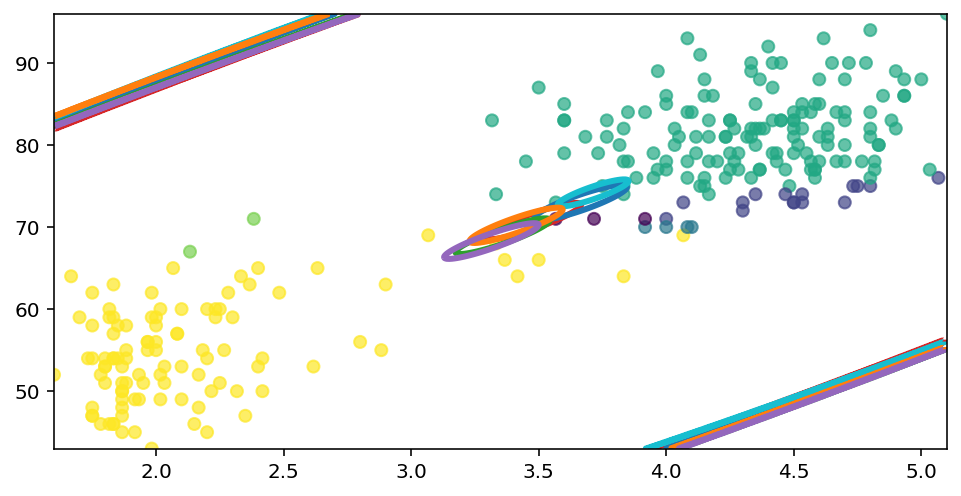

In [22]:
plot_mixtures(X, r_nk, mu_k, pi_k, Sigma_k)

##  Second Iteration

In [23]:
W_k = inv(W_k_inv)
E_logpi = digamma(alpha_k) - digamma(alpha_k.sum())
E_logLambda = digamma((eta_k + 1 - M) / 2) + M * np.log(2) + det(W_k)

In [24]:
diffk = (X[:, None, :] - m_k.T)
mpart = np.einsum("ijk, jkk -> ijk", diffk, W_k)
E_mahal = eta_k * np.einsum("ijk, ijk -> ij", mpart, diffk) + M / beta_k

In [25]:
log_rho_nk = E_logpi + E_logLambda / 2 - M / 2 * np.log(2 * np.pi) - E_mahal / 2
rho_nk = np.exp(log_rho_nk)
r_nk = rho_nk / rho_nk.sum(axis=-1, keepdims=True)

In [26]:
# Helpful identities
Nk = r_nk.sum(axis=0)
xbar_k = (X[..., None] * r_nk[:, None, :]).sum(axis=0) / Nk

Sk = (X[..., np.newaxis] - xbar_k)[..., None, :]
Sk = np.einsum("il, ijkl, ikjl -> kjl", r_nk, Sk, Sk) / Nk

In [27]:
# Helpful identities
Nk = r_nk.sum(axis=0)
xbar_k = (X[..., None] * r_nk[:, None, :]).sum(axis=0) / Nk

Sk = (X[..., np.newaxis] - xbar_k)[..., None, :]
Sk = np.einsum("il, ijkl, ikjl -> kjl", r_nk, Sk, Sk) / Nk

#### Variational M-step

In [28]:
alpha_k = alpha0 + Nk

In [29]:
beta_k = beta0 + Nk
m_k = (beta0 * m0 + xbar_k * Nk) / beta_k

In [30]:
eta_k = eta0 + Nk

C0 = (beta0 + Nk) / (beta0 * Nk)
f0 = (xbar_k - m0)[:, None, :]
W_k_inv = W0 + (Nk * Sk).T + np.einsum("ijk, jik -> kij", f0, f0) * C0[:, None, None ]

In [31]:
pi_k = dirichlet(alpha_k).mean()

### Expected Values

In [32]:
Lambda_k = [wishart(df=eta, scale=inv(w_inv)).mean()[None, ...] for eta, w_inv in zip(eta_k, W_k_inv)]
Lambda_k = np.concatenate(Lambda_k, axis=0)

In [33]:
mu_k = [multivariate_normal(mean=m, cov=inv(L * bk)).mean[None, ...] for m, L, bk in zip(m_k.T, Lambda_k, beta_k)]
mu_k = np.concatenate(mu_k, axis=0)

In [34]:
Sigma_k = inv(beta_k[:, None, None] * Lambda_k)

In [35]:
r_nk.sum(axis=0)

array([21.386, 52.045, 38.006, 78.018, 27.864, 54.68 ])

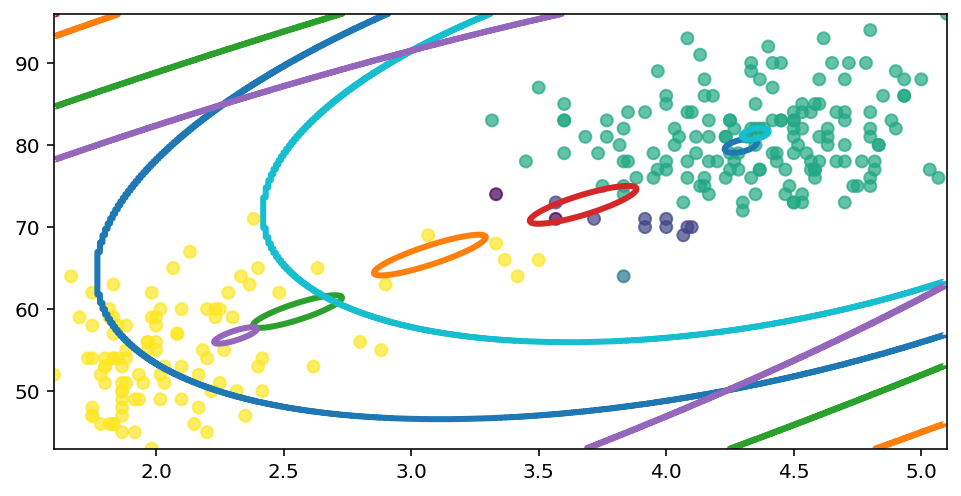

In [36]:
plot_mixtures(X, r_nk, mu_k, pi_k, Sigma_k)

# All together

In [37]:
def compute_e_log_pi(alpha):
    """
    Compute the expected value of every log pi_k, i.e.,
    compute ∀k. E[log pi_k]
    """
    return digamma(alpha) - digamma(alpha.sum())

def compute_e_log_lambda(X, eta, W):
    """
    Compute the expected value of every log det Lambda_k, i.e,
    compute ∀k. E[log|Lambda_k|]
    """
    N, M = X.shape
    return digamma((eta + 1 - M) / 2) + M * np.log(2) + det(W)

def compute_responsibilities(X, alpha, beta, eta, m, W):
    """
    Compute model responsibilities
    (Variational E-Step)
    """
    N, M = X.shape
    E_logpi = compute_e_log_pi(alpha)
    E_logLambda = compute_e_log_lambda(X, eta, W)
    diffk = (X[:, None, :] - m.T)
    mpart = np.einsum("ijk, jkk -> ijk", diffk, W)
    E_mahal = eta * np.einsum("ijk, ijk -> ij", mpart, diffk) + M / beta
    
    log_rho_nk = E_logpi + E_logLambda / 2 - M / 2 * np.log(2 * np.pi) - E_mahal / 2
    rho_nk = np.exp(log_rho_nk)
    
    # Responsibilities
    r = rho_nk / rho_nk.sum(axis=-1, keepdims=True)
    return r

def compute_m_statistics(X, r):
    Nk = r.sum(axis=0)
    xbar_k = (X[..., None] * r[:, None, :]).sum(axis=0) / Nk
    Sk = (X[..., np.newaxis] - xbar_k)[..., None, :]
    Sk = np.einsum("il, ijkl, ikjl -> kjl", r, Sk, Sk) / Nk
    
    return Nk, xbar_k, Sk


def posterior_params(X, r, alpha, beta, eta, m, W):
    """
    Compute the posterior parameters for each
    components of the mixture of gaussians
    (Variational M-Step)
    """
    Nk, xbar_k, Sk = compute_m_statistics(X, r)
    alpha_k = alpha + Nk
    beta_k = beta + Nk
    eta_k = eta + Nk
    
    m_k = (beta * m + Nk * xbar_k) / beta_k
    C0 = (beta * Nk) / (beta + Nk)
    f0 = (xbar_k - m)[:, None, :]
    W_k_inv = inv(W) + (Nk * Sk).T + C0[:, None, None] * np.einsum("ijk, jik -> kij", f0, f0)
    W_k = inv(W_k_inv)

    
    return alpha_k, beta_k, eta_k, m_k, W_k

def expected_values(X, r, alpha, beta, eta, m, W):
    pi_k = dirichlet(alpha).mean()
    Lambda_k = [wishart(df=eta_ki, scale=W_ki).mean()[None, ...]
                for eta_ki, W_ki in zip(eta, W)]
    Lambda_k = np.concatenate(Lambda_k, axis=0)
    
    mu_k = [multivariate_normal(mean=m_ki, cov=inv(bki * L_ki)).mean[None, ...]
            for m_ki, L_ki, bki in zip(m.T, Lambda_k, beta)]
    mu_k = np.concatenate(mu_k, axis=0)
    
    Sigma_k = inv(Lambda_k)
    
    return pi_k, mu_k, Sigma_k

In [151]:
# Prior parameters
seed(314)
N, M = X.shape
K = 6 # number of clusters
beta_0 = np.ones(K) 
m_0 = np.concatenate([X.mean(axis=0, keepdims=True).T] * K, axis=1) # np.ones((M, K))
m_0 = m0 + randn(M, K) * 2
alpha_0 = np.ones(K) 
eta_0 = 4 * np.ones(K)


W_0 = np.concatenate([np.identity(M)[None, ...]] * K, axis=0)  / 5

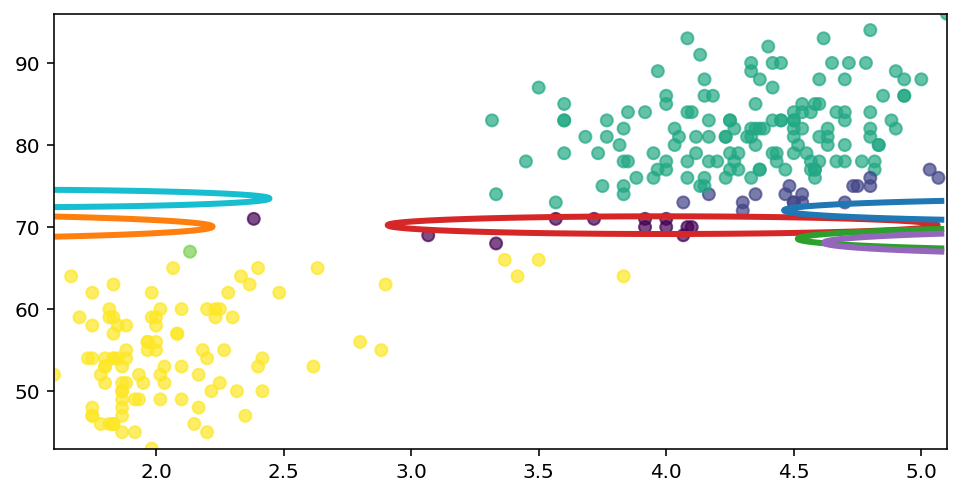

In [152]:
r_nk = compute_responsibilities(X, alpha_0, beta_0, eta_0, m_0, W_0)
pi_0, mu_0, Sigma_0 = expected_values(X, r_nk, alpha_0, beta_0, eta_0, m_0, W_0)
plot_mixtures(X, r_nk, mu_0, pi_0, Sigma_0)

In [153]:
steps = []
nits = 15
for _ in range(nits):
    alpha_k, beta_k, eta_k, m_k, W_k = posterior_params(X, r_nk, alpha_0, beta_0, eta_0, m_0, W_0)
    r_nk = compute_responsibilities(X, alpha_k, beta_k, eta_k, m_k, W_k)

    values = {
        "r": r_nk,
        "alpha": alpha_k,
        "beta": beta_k,
        "eta": eta_k,
        "m": m_k,
        "W": W_k
    }
    steps.append(values)

r_nk.sum(axis=0)

array([  0.025,   0.002,   0.002, 173.215,   0.007,  98.749])

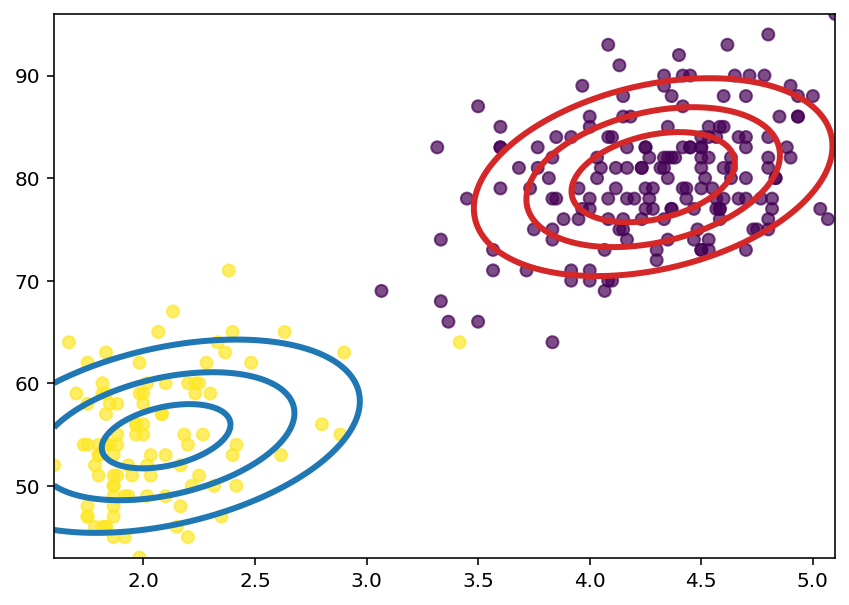

In [154]:
plt.figure(figsize=(7, 5))
pi_k, mu_k, Sigma_k = expected_values(X, r_nk, alpha_k, beta_k, eta_k, m_k, W_k)

plot_mixtures(X, r_nk,  mu_k, pi_k, Sigma_k, levels=3)

## Animating Convergence

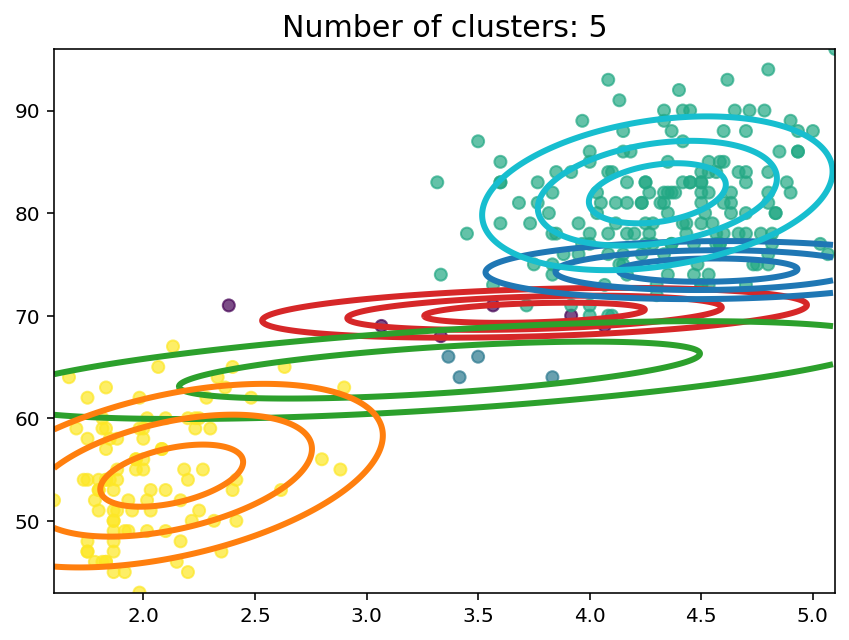

In [155]:
from matplotlib import animation

fig, ax = plt.subplots(figsize=(7, 5))

def animate(i):
    plt.cla()
    values = steps[i]
    r = values["r"]
    alpha = values["alpha"]
    beta = values["beta"]
    eta = values["eta"]
    m = values["m"]
    W = values["W"]
    pi_k, mu_k, Sigma_k = expected_values(X, r, alpha, beta, eta, m, W)
    plot_mixtures(X, r,  mu_k, pi_k, Sigma_k, levels=3)
    nclusters = (r.sum(axis=0) > 1).sum()
    plt.title(f"Number of clusters: {nclusters}", fontsize=15)
    
ani = animation.FuncAnimation(fig, animate, nits, interval=200)
ani.save("/Users/gerardoduran/Desktop/variational2.gif", fps=5, dpi=150, writer="imagemagick")

## Lower Bound

To moitor the implementation of the GMM, it is useful to compute the lower bound at each step of the the training process. At each step, this bound should not decrease.

For the GMM, the lower bound is given by

$$
    \mathcal{L} = \sum_{\bf Z}\iiint q({\bf Z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \Lambda})\log\left\{\frac{p({\bf X}, {\bf Z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \Lambda})}{q({\bf Z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \Lambda})}\right\} d{\boldsymbol \pi}d{\boldsymbol \mu} d{\boldsymbol \Lambda}
$$

In [44]:
def B(W, eta):
    """
    Compute the normalization coefficient
    for the Wishart Distribution
    """
    W0, *_ = W
    eta0, *_ = eta
    M, *_ = W0.shape
    term1 = det(W0) ** (- eta0 / 2)
    term2 = (np.power(2, M * eta0 / 2)
           * np.power(np.pi, M * (M - 1) / 4)
           * gamma((eta0 + 1 - np.arange(M)) / 2).prod())
    return term1 / term2

def compute_log_C(alpha):
    """
    Compute the log-transformation of the dirichlet
    normalization constant
    
    Parameters
    ----------
    alpha: np.array(K,)
        {αi}i components of a dirichlet
        
    Returns
    -------
    float: log(C(α)) = log Γ(Σi α_i) - Σi Γ(alpha_i)
    """
    return loggamma(alpha.sum()) - loggamma(alpha).sum()

In [137]:
def E1(X, r, beta, eta, m, W):
    """
    E[log p(X|Z,μ,Λ)]
    """
    N, M = X.shape
    Nk, xbar_k, Sk = compute_m_statistics(X, r)
    log_hat_Λ = compute_e_log_lambda(X, eta, W)
    Tr_Sk_Wk = np.einsum("ijm,mji->m", Sk, W)
    diffk = xbar_k - m
    mahal_xbar = np.einsum("im,mij,jm->m", diffk, W, diffk)
    
    E_val = Nk * (log_hat_Λ - M / beta - eta * Tr_Sk_Wk
                  - eta * mahal_xbar - M * np.log(2 * np.pi)) / 2
    
    return E_val.sum()


def E2(X, r, alpha, beta, m, W):
    """
    E[log p(Z|π)]
    """
    log_hat_π = compute_e_log_pi(alpha)
    E_val = np.einsum("ik,k->", r, log_hat_π)
    
    return E_val.sum()


def E3(X, r, alpha, alpha_0):
    """
    E[log p(π)]
    """
    log_C_α0 = compute_log_C(alpha_0)
    log_hat_π = compute_e_log_pi(alpha)
    
    return log_C_α0 + (alpha_0[0] - 1) * log_hat_π.sum()


def E4(X, r, beta, eta, m, W, beta_0, eta_0, m_0, W_0):
    """
    E[log p(μ, Λ)]
    """
    N, M = X.shape
    K, *_ = eta.shape
    diffk = m - m_0
    log_hat_Λ = compute_e_log_lambda(X, eta, W)
    mahal_mk = np.einsum("im,mij,jm->m", diffk, W, diffk)
    Tr_W0inv_W = np.einsum("mij,mij->m", inv(W_0), W)
    
    term1 = (M * np.log(beta_0[0] / (np.pi * 2))
             + log_hat_Λ - M * beta_0 / beta - beta_0 * eta * mahal_mk).sum() / 2
    term2 = K * np.log(B(W_0, eta_0))
    term3 = (eta_0[0] - M - 1) / 2 * log_hat_Λ.sum()
    term4 = (eta * Tr_W0inv_W).sum() / 2
    
    E_val = term1 + term2 + term3 - term4
    
    return E_val


def E5(r):
    """
    E[log q(Z)]
    """
    return (r * np.log(r)).sum()


def E6(alpha):
    """
    E[log q(π)]
    """
    log_hat_π = compute_e_log_pi(alpha)
    term1 = (alpha - 1) * log_hat_π
    term2 = compute_log_C(alpha)
    E_val = term1.sum() + term2
    
    return E_val


def E7(X, beta, eta, W):
    """
    E[log q(μ, Λ)]
    """
    N, M = X.shape
    log_hat_Λ = compute_e_log_lambda(X, eta, W)
    # Entropy of the Wishart distribution ∀ k
    H = np.array([wishart.entropy(eta_ki, W_ki) for W_ki, eta_ki in zip(W, eta)])
    E_val = log_hat_Λ / 2 + M * np.log(beta / (2 * np.pi)) / 2 - M / 2 - H
    
    return E_val.sum()

def gmm_lower_bound(X, r, alpha, beta, eta, m, W, beta_0, eta_0, m_0, W_0):
    """
    Compute the variational lower bound for the variational distribution of
    a mixture of gaussians.
    """
    E1_val = E1(X, r, beta, eta, m, W)
    E2_val = E2(X, r, alpha, beta, m, W)
    E3_val = E3(X, r, alpha, alpha_0)
    E4_val = E4(X, r, beta, eta, m, W, beta_0, eta_0, m_0, W_0)
    E5_val = E5(r)
    E6_val = E6(alpha)
    E7_val = E7(X, beta, eta, W)
    
    return E1_val + E2_val + E3_val  + E4_val - E5_val - E6_val - E7_val

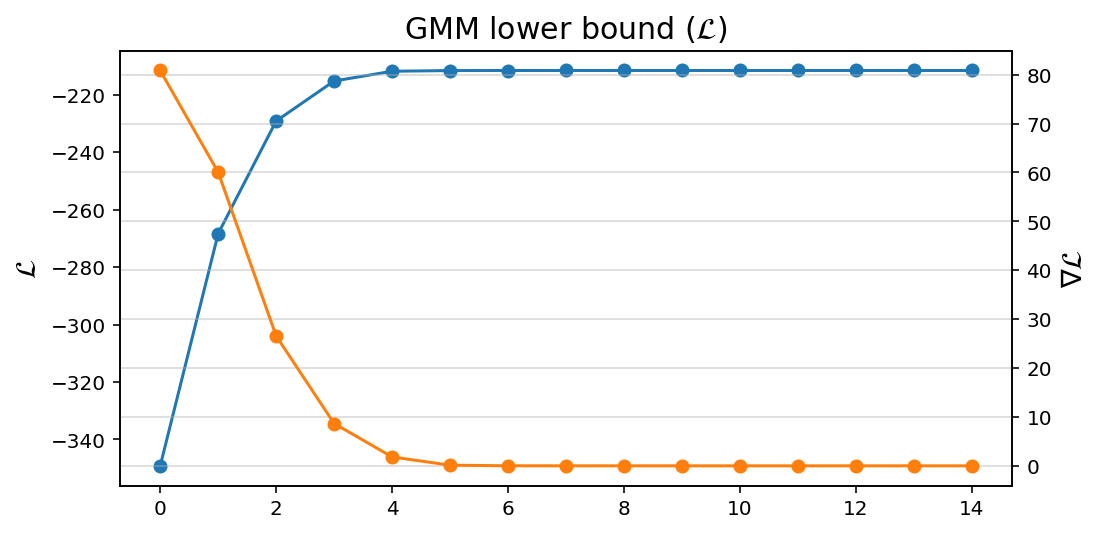

In [182]:
Lbound_hist = []
for step in steps:
    rn_k = step["r"]
    alpha_k = step["alpha"]
    beta_k = step["beta"]
    eta_k = step["eta"]
    m_k = step["m"]
    W_k = step["W"]
    L = gmm_lower_bound(X, r_nk, alpha_k, beta_k, eta_k, m_k, W_k, beta_0, eta_0, m_0, W_0)
    Lbound_hist.append(L)
    
fig, ax = plt.subplots()
ax2 = ax.twinx()
xhist = np.ones_like(Lbound_hist).cumsum() - 1
ax.plot(xhist, Lbound_hist, marker="o")
ax2.plot(xhist, np.gradient(Lbound_hist), marker="o", c="tab:orange")
ax.set_ylabel("$\mathcal{L}$", fontsize=14)
ax2.set_ylabel(r"$\nabla \mathcal{L}$", fontsize=14)
ax2.grid(alpha=0.5)
plt.title(r"GMM lower bound ($\mathcal{L}$)", fontsize=15);